In [1]:
!pip install torch torchvision


  Using cached torchvision-0.19.1-cp39-cp39-win_amd64.whl (1.3 MB)


Training the FixMatch model...
Starting Epoch 1/10
Epoch 1 Completed. Average Loss: 1.8606
Starting Epoch 2/10
Epoch 2 Completed. Average Loss: 1.1212
Starting Epoch 3/10
Epoch 3 Completed. Average Loss: 0.5584
Starting Epoch 4/10
Epoch 4 Completed. Average Loss: 0.1811
Starting Epoch 5/10
Epoch 5 Completed. Average Loss: 0.0553
Starting Epoch 6/10
Epoch 6 Completed. Average Loss: 0.0247
Starting Epoch 7/10
Epoch 7 Completed. Average Loss: 0.0156
Starting Epoch 8/10
Epoch 8 Completed. Average Loss: 0.0144
Starting Epoch 9/10
Epoch 9 Completed. Average Loss: 0.0073
Starting Epoch 10/10
Epoch 10 Completed. Average Loss: 0.0118
Training completed!
Evaluating the model...
Classification Report:
               precision    recall  f1-score   support

        Crime       0.57      0.39      0.46       335
    Editorial       0.52      0.27      0.36      1021
    Education       0.66      0.41      0.51       308
Entertainment       0.76      0.74      0.75       788
      Finance       0.67

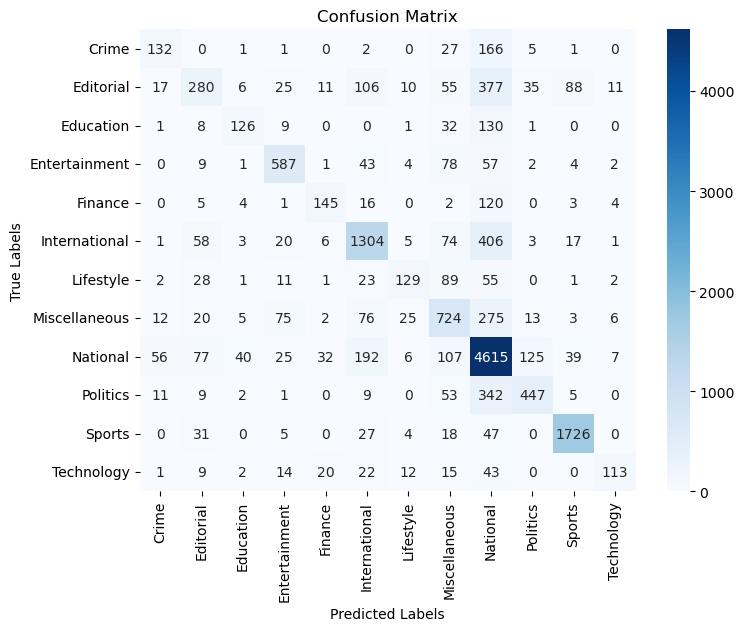

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from scipy import sparse

# Dataset paths
file_path = 'F:\\Masters 2nd Semester\\Thesis\\NewsPaper\\bangla.csv'  # Your dataset path

# Load and preprocess the data
data = pd.read_csv(file_path)
data.dropna(inplace=True)

# Encode categories
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return self.texts.shape[0]
    
    def __getitem__(self, idx):
        text = self.texts[idx].toarray().squeeze()
        label = self.labels[idx] if self.labels is not None else -1
        return torch.tensor(text, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Prepare the input features and labels
X = data[['headline', 'content']]
y = data['category']

# Vectorize the 'headline' and 'content' columns separately
tfidf_headline = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_content = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

headline_features = tfidf_headline.fit_transform(X['headline'])
content_features = tfidf_content.fit_transform(X['content'])

# Combine the TF-IDF features
combined_features = sparse.hstack([headline_features, content_features])

# Split the data into training and unlabeled data
n_labeled = int(0.2 * len(data))  # 10% of the data is labeled
train_texts = combined_features[:n_labeled]
train_labels = y[:n_labeled].values

unlabeled_texts = combined_features[n_labeled:]

# Create PyTorch Datasets and DataLoaders
train_dataset = TextDataset(train_texts, train_labels)
unlabeled_dataset = TextDataset(unlabeled_texts)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)

# FixMatch Model Definition
class FixMatchModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FixMatchModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = combined_features.shape[1]
num_classes = len(label_encoder.classes_)

# Initialize the FixMatch model, optimizer, and loss function
fixmatch_model = FixMatchModel(input_dim, num_classes)
optimizer = optim.Adam(fixmatch_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# FixMatch Training Function
def train_fixmatch(model, optimizer, train_loader, unlabeled_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        print(f"Starting Epoch {epoch + 1}/{num_epochs}")
        for (x_labeled, y_labeled), (x_unlabeled, _) in zip(train_loader, unlabeled_loader):
            # Convert labels to LongTensor
            y_labeled = y_labeled.long()
            
            # Forward pass for labeled data
            outputs = model(x_labeled)
            loss = criterion(outputs, y_labeled)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} Completed. Average Loss: {avg_loss:.4f}")

# Train the FixMatch model
print("Training the FixMatch model...")
train_fixmatch(fixmatch_model, optimizer, train_loader, unlabeled_loader)
print("Training completed!")

# Prepare test set
test_texts = combined_features[:len(data)]  # Replace with actual test features if available
test_labels = y.values  # Replace with actual test labels if available

test_dataset = TextDataset(test_texts, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return all_labels, all_preds

print("Evaluating the model...")
all_labels, all_preds = evaluate_model(fixmatch_model, test_loader)

# Print evaluation results
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Training the Pseudo-Label model...
Starting Epoch 1/10
Epoch 1 Completed. Average Loss: 0.3753
Starting Epoch 2/10
Epoch 2 Completed. Average Loss: 0.3301
Starting Epoch 3/10
Epoch 3 Completed. Average Loss: 0.2402
Starting Epoch 4/10
Epoch 4 Completed. Average Loss: 0.1724
Starting Epoch 5/10
Epoch 5 Completed. Average Loss: 0.1434
Starting Epoch 6/10
Epoch 6 Completed. Average Loss: 0.1476
Starting Epoch 7/10
Epoch 7 Completed. Average Loss: 0.0752
Starting Epoch 8/10
Epoch 8 Completed. Average Loss: 0.0366
Starting Epoch 9/10
Epoch 9 Completed. Average Loss: 0.0363
Starting Epoch 10/10
Epoch 10 Completed. Average Loss: 0.0245
Training completed!
Evaluating the model...
Classification Report:
               precision    recall  f1-score   support

        Crime       0.82      0.13      0.22       335
    Editorial       0.85      0.13      0.23      1021
    Education       0.83      0.24      0.37       308
Entertainment       0.84      0.68      0.75       788
      Finance       

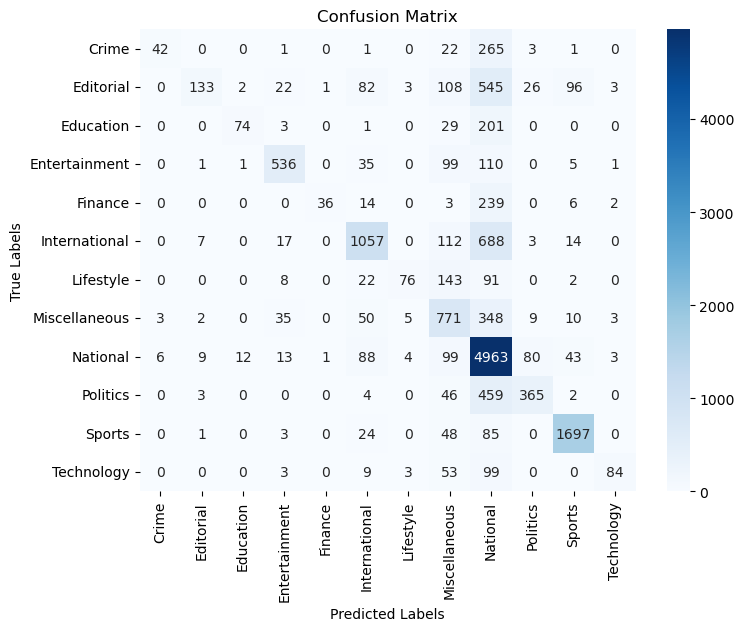

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

# Dataset paths
file_path = 'F:\\Masters 2nd Semester\\Thesis\\NewsPaper\\bangla.csv'  # Your dataset path

# Load and preprocess the data
data = pd.read_csv(file_path)
data.dropna(inplace=True)

# Encode categories
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(data['category'])

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return self.texts.shape[0]
    
    def __getitem__(self, idx):
        text = self.texts[idx].toarray().squeeze()
        label = self.labels[idx] if self.labels is not None else -1
        return torch.tensor(text, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Prepare the input features and labels
X = data[['headline', 'content']]
y = data['category']

# Vectorize the 'headline' and 'content' columns separately
tfidf_headline = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_content = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

headline_features = tfidf_headline.fit_transform(X['headline'])
content_features = tfidf_content.fit_transform(X['content'])

# Combine the TF-IDF features
combined_features = sparse.hstack([headline_features, content_features])

# Split the data into training and unlabeled data
n_labeled = int(0.2 * len(data))  # 20% of the data is labeled
train_texts = combined_features[:n_labeled]
train_labels = y[:n_labeled].values

unlabeled_texts = combined_features[n_labeled:]

# Create PyTorch Datasets and DataLoaders
train_dataset = TextDataset(train_texts, train_labels)
unlabeled_dataset = TextDataset(unlabeled_texts)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)

# Pseudo-Label Model Definition
class PseudoLabelModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PseudoLabelModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = combined_features.shape[1]
num_classes = len(label_encoder.classes_)

# Initialize the Pseudo-Label model, optimizer, and loss function
pseudo_label_model = PseudoLabelModel(input_dim, num_classes)
optimizer = optim.Adam(pseudo_label_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Pseudo-Labeling Training Function
def train_pseudo_label(model, optimizer, train_loader, unlabeled_loader, threshold=0.9, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        print(f"Starting Epoch {epoch + 1}/{num_epochs}")
        
        # Train on labeled data
        for (x_labeled, y_labeled) in train_loader:
            y_labeled = y_labeled.long()  # Ensure labels are of type long
            
            # Forward pass for labeled data
            outputs = model(x_labeled)
            loss = criterion(outputs, y_labeled)
            
            # Backpropagation and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update model parameters
            
            total_loss += loss.item()
        
        # Pseudo-Labeling for unlabeled data
        for (x_unlabeled, _) in unlabeled_loader:
            # Generate pseudo-labels
            outputs = model(x_unlabeled)
            probs = torch.softmax(outputs, dim=1)
            max_probs, pseudo_labels = torch.max(probs, dim=1)
            
            # Select high-confidence pseudo-labels
            high_conf_mask = max_probs > threshold
            x_pseudo = x_unlabeled[high_conf_mask]
            y_pseudo = pseudo_labels[high_conf_mask]
            
            if len(x_pseudo) > 0:
                # Ensure y_pseudo is of type long
                y_pseudo = y_pseudo.long()  
                
                # Forward pass for pseudo-labeled data
                outputs = model(x_pseudo)
                loss = criterion(outputs, y_pseudo)
                
                # Backpropagation and optimization
                optimizer.zero_grad()  # Clear gradients
                loss.backward()        # Backpropagate the loss
                optimizer.step()       # Update model parameters
                
                total_loss += loss.item()
        
        avg_loss = total_loss / (len(train_loader) + len(unlabeled_loader))
        print(f"Epoch {epoch + 1} Completed. Average Loss: {avg_loss:.4f}")

# Train the Pseudo-Label model
print("Training the Pseudo-Label model...")
train_pseudo_label(pseudo_label_model, optimizer, train_loader, unlabeled_loader)
print("Training completed!")

# Prepare test set
test_texts = combined_features[:len(data)]  # Replace with actual test features if available
test_labels = y.values  # Replace with actual test labels if available

test_dataset = TextDataset(test_texts, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return all_labels, all_preds

print("Evaluating the model...")
all_labels, all_preds = evaluate_model(pseudo_label_model, test_loader)

# Print evaluation results
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
